# Module 4.A Probability Fundamentals on NYC 311

This module applies the **Module 4.A** ideas to the NYC 311 feature table  
* **Random variables:** define events as boolean random variables (0/1)
* **Marginals:** compute baseline rates like `P(fast)`
* **Conditionals:** compute `P(fast | noise)` vs `P(noise | fast)` and interpret denominators
* **Bayes reversal:** relate `P(A|B)` and `P(B|A)` using empirical counts

**Deliverable:**  
A short written narrative describing one probability story that was discovered

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

rng = np.random.default_rng(42)

## 4A.1 Load the normalized NYC 311 table - From 3.A

In [2]:
M3_DATA_DIR = Path("work/m3/data")
NORM_PATH = M3_DATA_DIR / "nyc311_features_norm.parquet"

if not NORM_PATH.exists():
    raise FileNotFoundError(
        f"Missing normalized cache at {NORM_PATH}. "
        "Run Module 3.A first to create it."
    )

df = pd.read_parquet(NORM_PATH)
print("Loaded:", NORM_PATH)
print("Shape:", df.shape)
df.head(3)


Loaded: work/m3/data/nyc311_features_norm.parquet
Shape: (50000, 25)


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,2.C_features_parquet,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,2.C_features_parquet,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet,4


## 4A.2 Define an analysis slice - so probabilities are meaningful

Probability statements are only as meaningful as the population you compute them on.  

For this section, we will:  
* focus on **closed cases**, where `resolution_hours` is observed
* require a sane, non-negative `resolution_hours`
* explicitly acknowledge **right-censoring**: near the end of the time window, long-running cases may still be open.

If `P(fast)` is computed over all rows (including open cases), the "observed outcomes" and "unknown outcomes" are being mixed. That is rarely the problem that should be looked at.

In [3]:
df2 = df.copy()

# Determine closed cases (robust to different schemas)
if "is_closed" in df2.columns:
    is_closed = df2["is_closed"] == 1
elif "status" in df2.columns:
    is_closed = df2["status"].astype(str).str.upper().isin(["CLOSED", "RESOLVED"])
else:
    is_closed = pd.Series([True] * len(df2), index=df2.index)

if "resolution_hours" not in df2.columns:
    raise ValueError("Expected 'resolution_hours' to exist (created in earlier modules / normalized in 3.A).")

y = df2["resolution_hours"].astype(float)

mask = is_closed & y.notna() & np.isfinite(y) & (y >= 0)
d = df2.loc[mask].copy()

print("Closed + valid resolution_hours slice:")
print("Shape:", d.shape)
d[["agency", "borough_norm", "complaint_topk", "resolution_hours"]].head(5)


Closed + valid resolution_hours slice:
Shape: (18894, 25)


,agency,borough_norm,complaint_topk,resolution_hours
41,NYPD,BRONX,noise - residential,0.373056
43,NYPD,QUEENS,illegal parking,0.181667
45,NYPD,QUEENS,illegal parking,0.353056
49,NYPD,BRONX,other,0.300278
51,NYPD,MANHATTAN,other,0.095000


### Quick sanity check: How heavy is the tail?  

Tail heaviness impacts how stable probabilities are; especially for thresholds like "resolved within 24 hours."

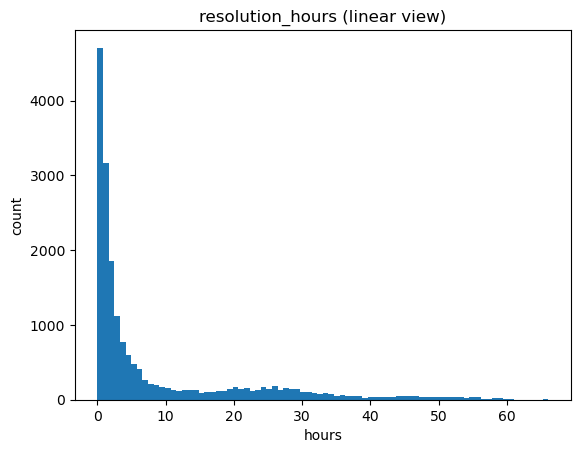

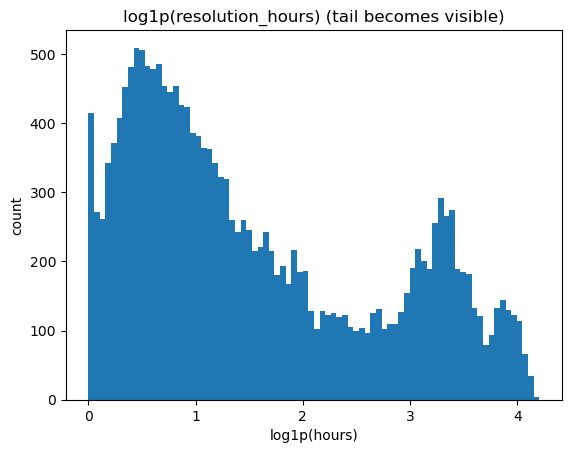

In [4]:
plt.figure()
plt.hist(d["resolution_hours"], bins=80)
plt.title("resolution_hours (linear view)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(d["resolution_hours"]), bins=80)
plt.title("log1p(resolution_hours) (tail becomes visible)")
plt.xlabel("log1p(hours)")
plt.ylabel("count")
plt.show()

## 4A.3 Define events - boolean random variables  

We will create a few events that can be reused throughout Module 4:  
* `fast_24`: resolved within 24 hours
* `fast_72`: resolved within 72 hours
* `noise`: a noise complaint indicator
* `rodent`: rodent-related indicator

**Important:**  
Event definitions are part of the *data contract*. Small definition changes can flip conclusions.

In [5]:
# Event: fast resolution
d["fast_24"] = d["resolution_hours"] <= 24
d["fast_72"] = d["resolution_hours"] <= 72

# Event: noise complaint (use the most reliable signal available)
if "kw_noise" in d.columns:
    d["noise"] = d["kw_noise"].astype(int) == 1
else:
    # Fall back to complaint_topk text match if keyword feature doesn't exist
    ct = d["complaint_topk"].astype(str).str.lower()
    d["noise"] = ct.str.contains("noise")

# Event: rodent complaint (nice for base-rate demonstrations)
if "kw_rodent" in d.columns:
    d["rodent"] = d["kw_rodent"].astype(int) == 1
else:
    ct = d["complaint_topk"].astype(str).str.lower()
    d["rodent"] = ct.str.contains("rodent|rat|mice|mouse")

# A quick look at event prevalence
event_cols = ["fast_24", "fast_72", "noise", "rodent"]
d[event_cols].mean().sort_values(ascending=False)

fast_72    1.000000
fast_24    0.853975
noise      0.099608
rodent     0.003811
dtype: float64

## 4A.4 Marginal probabilites - baseline rates

A **marginal probability** is just the baseline rate in the chosen population.  

Examples:
* `P(fast_24)`: fraction of closed cases resolved within 24 hours
* `P(noise)`: fraction of closed cases that are noise-related

These are the base rates that anchor interpretation.

In [6]:
def p(series: pd.Series) -> float:
    """Probability estimate for a boolean (or 0/1) series."""
    s = series.astype(bool)
    return float(s.mean())

marginals = pd.Series({
    "P(fast_24)": p(d["fast_24"]),
    "P(fast_72)": p(d["fast_72"]),
    "P(noise)": p(d["noise"]),
    "P(rodent)": p(d["rodent"]),
}).sort_values(ascending=False)

marginals

P(fast_72)    1.000000
P(fast_24)    0.853975
P(noise)      0.099608
P(rodent)     0.003811
dtype: float64

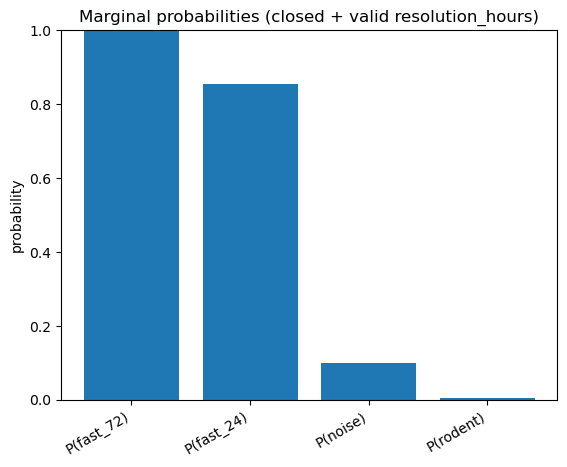

In [7]:
# Visualize marginals
plt.figure()
plt.bar(marginals.index, marginals.values)
plt.title("Marginal probabilities (closed + valid resolution_hours)")
plt.ylabel("probability")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, min(1.0, max(marginals.values) * 1.15 + 0.02))
plt.show()


## 4A.5 Conditional probabilities - denominators matter  

Conditional probability answers:  

Among cases where **B** is true, how often is **A** true?  

We will compare: 
* `P(fast_24 | noise)` vs `P(noise | fast_24)`

A reliable workflow is:
* Build a contingency table
* Compute row/column-normalized rates with explicit denominators

In [8]:
def conditional(A: pd.Series, B: pd.Series) -> float:
    """Compute P(A | B) on booleans A, B with safe handling."""
    A = A.astype(bool)
    B = B.astype(bool)
    denom = B.sum()
    if denom == 0:
        return float("nan")
    return float((A & B).sum() / denom)

A = d["fast_24"]
B = d["noise"]

p_fast_given_noise = conditional(A, B)
p_noise_given_fast = conditional(B, A)

print("P(fast_24 | noise) =", p_fast_given_noise)
print("P(noise | fast_24) =", p_noise_given_fast)


P(fast_24 | noise) = 0.9814027630180658
P(noise | fast_24) = 0.11447164549116827


In [9]:
# Contingency table for (noise, fast_24)
ct = pd.crosstab(d["noise"], d["fast_24"], rownames=["noise"], colnames=["fast_24"])
ct


fast_24,False,True
noise,,
False,2724,14288
True,35,1847


In [10]:
# Convert contingency table to conditional probabilities
# Row-normalized: P(fast_24 | noise)
row_norm = ct.div(ct.sum(axis=1), axis=0)

# Column-normalized: P(noise | fast_24)
col_norm = ct.div(ct.sum(axis=0), axis=1)

print("Row-normalized (P(fast_24 | noise)):")
display(row_norm)

print("\nColumn-normalized (P(noise | fast_24)):")
display(col_norm)

Row-normalized (P(fast_24 | noise)):


fast_24,False,True
noise,,
False,0.160122,0.839878
True,0.018597,0.981403



Column-normalized (P(noise | fast_24)):


fast_24,False,True
noise,,
False,0.987314,0.885528
True,0.012686,0.114472


### Visual intuition: Same table, different denominators  

Now visualize the row-normalized table as a simple heatmap

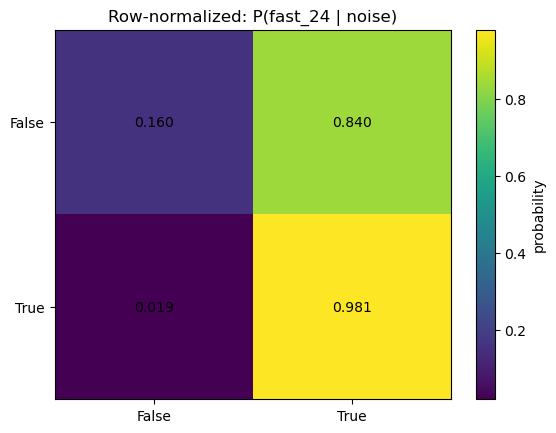

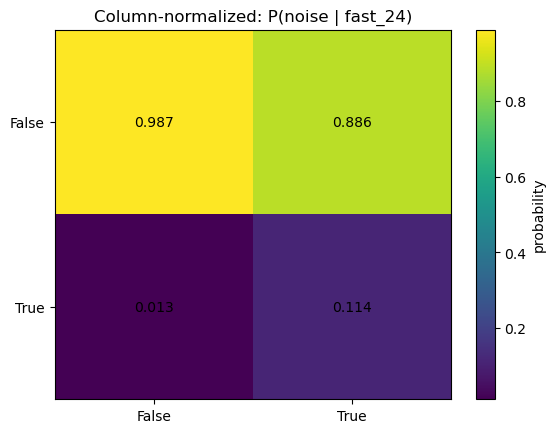

In [11]:
# Simple heatmap helper
def heatmap(df_heat: pd.DataFrame, title: str):
    plt.figure()
    arr = df_heat.to_numpy()
    plt.imshow(arr, aspect="auto")
    plt.title(title)
    plt.xticks(range(df_heat.shape[1]), [str(c) for c in df_heat.columns])
    plt.yticks(range(df_heat.shape[0]), [str(i) for i in df_heat.index])
    plt.colorbar(label="probability")
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            plt.text(j, i, f"{arr[i, j]:.3f}", ha="center", va="center")
    plt.show()

heatmap(row_norm, "Row-normalized: P(fast_24 | noise)")
heatmap(col_norm, "Column-normalized: P(noise | fast_24)")

## 4A.6 Bayes-style reversal - using empirical counts

Bayes' theorem says:
$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

With data, we can compute each term empirically and verify the relationship.
* `A = noise`
* `B = fast_24`

Then check:
$$P(noise | fast) \approx \frac{P(fast\_24 | noise) \cdot P(noise)}{P(fast\_24)}$$

If there is a mismatch, it is usually due to 
* sampling noise (small counts)
* inconsistent slicing (different denominators)
* missingness / filtering differences

In [12]:
P_noise = p(d["noise"])
P_fast = p(d["fast_24"])

P_fast_given_noise = conditional(d["fast_24"], d["noise"])
P_noise_given_fast_direct = conditional(d["noise"], d["fast_24"])

# Bayes reversal estimate
P_noise_given_fast_bayes = (P_fast_given_noise * P_noise) / P_fast if P_fast > 0 else float("nan")

print("Empirical terms:")
print("P(noise) =", P_noise)
print("P(fast_24) =", P_fast)
print("P(fast_24 | noise) =", P_fast_given_noise)
print("\nDirect:  P(noise | fast_24) =", P_noise_given_fast_direct)
print("Bayes:   P(noise | fast_24) =", P_noise_given_fast_bayes)
print("\nAbsolute difference =", abs(P_noise_given_fast_direct - P_noise_given_fast_bayes))


Empirical terms:
P(noise) = 0.0996083412723616
P(fast_24) = 0.8539748068169789
P(fast_24 | noise) = 0.9814027630180658

Direct:  P(noise | fast_24) = 0.11447164549116827
Bayes:   P(noise | fast_24) = 0.11447164549116827

Absolute difference = 0.0


### Where does Bayes reversal matter most?  

Bayes reversal can become confusing when **base rates are tiny**. 

We will repeat the exercise with a rare event (`rodent`), which tends to create larger gaps between:  
* How often do rodent cases resolve fast: `P(fast_24 | rodent)`
* Among fast-resolved cases, how often are they rodent: `P(rodent | fast_24)`



In [13]:
def bayes_report(A_name: str, A: pd.Series, B_name: str, B: pd.Series) -> pd.Series:
    A = A.astype(bool)
    B = B.astype(bool)
    PA = p(A)
    PB = p(B)
    PB_given_A = conditional(B, A)
    PA_given_B_direct = conditional(A, B)
    PA_given_B_bayes = (PB_given_A * PA) / PB if PB > 0 else float("nan")

    return pd.Series({
        "P(A)": PA,
        "P(B)": PB,
        "P(B|A)": PB_given_A,
        "P(A|B) direct": PA_given_B_direct,
        "P(A|B) via Bayes": PA_given_B_bayes,
        "abs diff": abs(PA_given_B_direct - PA_given_B_bayes),
        "A": A_name,
        "B": B_name,
    })

rep_noise = bayes_report("noise", d["noise"], "fast_24", d["fast_24"])
rep_rodent = bayes_report("rodent", d["rodent"], "fast_24", d["fast_24"])

pd.DataFrame([rep_noise, rep_rodent])[["A","B","P(A)","P(B)","P(B|A)","P(A|B) direct","P(A|B) via Bayes","abs diff"]]


,A,B,P(A),P(B),P(B|A),P(A|B) direct,P(A|B) via Bayes,abs diff
0,noise,fast_24,0.099608,0.853975,0.981403,0.114472,0.114472,0.0
1,rodent,fast_24,0.003811,0.853975,0.791667,0.003533,0.003533,0.0


## 4A.7 Probability story mining: segment by group  

A common workflow in ML is: 
1. compute baseline rates
2. compute conditional rates by subgroup
3. identify where the story changes

Compute `P(fast_24 | group)` by `agency`

In [14]:
group_col = "agency" if "agency" in d.columns else None
if group_col is None:
    raise ValueError("Expected an 'agency' column in your NYC 311 feature table.")

rates = (
    d.groupby(group_col)["fast_24"]
     .mean()
     .sort_values(ascending=False)
)

rates.head(10)

agency
NYPD     0.999738
DEP      0.926864
DOT      0.912583
DOB      0.857143
DOE      0.853333
DPR      0.851485
DOHMH    0.760000
DCWP     0.750000
DHS      0.709251
TLC      0.655172
Name: fast_24, dtype: float64

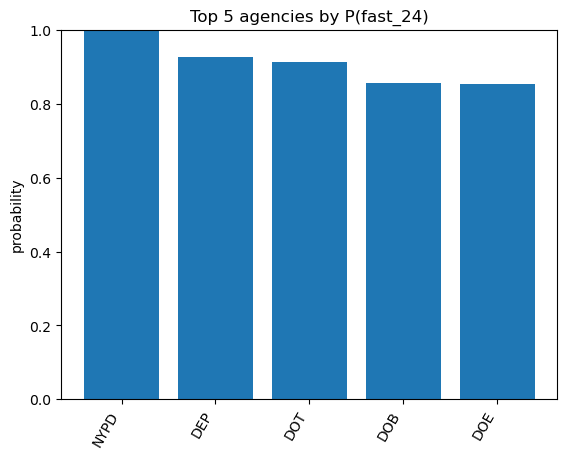

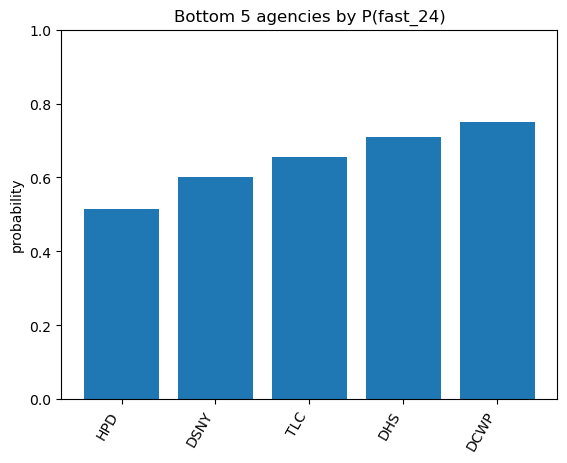

In [15]:
# Plot the top/bottom agencies by P(fast_24)
top_n = 5
top = rates.head(top_n)
bot = rates.tail(top_n).sort_values(ascending=True)

plt.figure()
plt.bar(top.index.astype(str), top.values)
plt.title(f"Top {top_n} agencies by P(fast_24)")
plt.ylabel("probability")
plt.xticks(rotation=60, ha="right")
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.bar(bot.index.astype(str), bot.values)
plt.title(f"Bottom {top_n} agencies by P(fast_24)")
plt.ylabel("probability")
plt.xticks(rotation=60, ha="right")
plt.ylim(0, 1)
plt.show()

### Add conditioning: is the "fast" story different for noise?  

Compute `P(fast_24 | noise, agency)` and compare it with `P(fast_24 | agency)`  

This helps separate:
* "the agency is slow overall" from
* "the agency handles a harder mix of cases"

In [16]:
# P(fast_24 | agency) baseline already computed as `rates`
baseline = rates.rename("P(fast_24 | agency)")

# Condition on noise
dn = d.loc[d["noise"]].copy()
rates_noise = dn.groupby("agency")["fast_24"].mean().rename("P(fast_24 | noise, agency)")

comparison = (
    pd.concat([baseline, rates_noise], axis=1)
      .dropna()
)
comparison["delta (noise - baseline)"] = comparison["P(fast_24 | noise, agency)"] - comparison["P(fast_24 | agency)"]
comparison.sort_values("delta (noise - baseline)").head(12)


,P(fast_24 | agency),"P(fast_24 | noise, agency)",delta (noise - baseline)
agency,,,
DEP,0.926864,0.779874,-0.146989
NYPD,0.999738,1.000000,0.000262


## 4A.8 Deliverable: Write the probability story

Write a short narrative:
* What population was chosen (the slice)?
* What events were defined, and why?
* What were the most important base rates?
* Which conditional probability was most decision-relevant, and why?
* Where did Bayes reversal create the biggest difference in intuition?
* What should be done differently in a modeling pipeline because of this?

Complete the following template

### My NYC311 probability story  

* **Population / slice:** Closed NYC311 cases with a valid, non-negative `resolution_hours`
* **Events(A, B) defined:** A = `noise`, was the complaint noise related , B = `fast_24` was it resolved within 24 hours
* **Base rates:** `P(A)` = 0.0996 (&approx;10%), `P(B)` = 0.8540 (&approx;85%)
* **Key conditional:** `P(A | B)` = 0.9814, **means** that among noise complaints &approx;98.1% are resolved within 24 hours.
* **Reversal conditional:** `P(B | A)` = 0.1145, **means** that among fast resolving cases &approx;11.5% were noise related
* **Bayes reversal insight:** Even though noise is almost always fast, it does not dominate the fast group
* **What was surprising:** Globally, noise complaints look very fast. However, when comparing by agency, some are significantly worse.
* **How this changes modeling/evaluation choices:** Segment by group before drawing conclusions

## 4A.Appendix Tiny helper pattern

This is a reusable "probability toolkit" for later modules.

In [17]:
# Reusable helpers

def prob_table(A: pd.Series, B: pd.Series, A_name="A", B_name="B") -> pd.DataFrame:
    A = A.astype(bool)
    B = B.astype(bool)

    out = {
        f"P({A_name})": p(A),
        f"P({B_name})": p(B),
        f"P({A_name} | {B_name})": conditional(A, B),
        f"P({B_name} | {A_name})": conditional(B, A),
        f"P({A_name} & {B_name})": float((A & B).mean()),
    }
    return pd.DataFrame([out])

prob_table(d["noise"], d["fast_24"], A_name="noise", B_name="fast_24")


,P(noise),P(fast_24),P(noise | fast_24),P(fast_24 | noise),P(noise & fast_24)
0,0.099608,0.853975,0.114472,0.981403,0.097756


# Module 4.B Common Distributions on NYC 311

This lab connects three workhorse distributions to real NYC 311 data:  
* **Poisson:** event counts per window (e.g. requests per hour/day)
* **Binomial:** number of "successes" out of **N** opportunities (e.g., fast resolutions out of all cases)
* **Normal:** often a model for *aggregates* (averages/residuals), not raw counts or raw durations

The focus is not "fitting curves", but **assumptions** and **failure modes:**
* constant rate vs seasonality/bursts
* independence vs clustering
* same-p vs mixture by group
* symmetry vs heavy tails

**Deliverable:**  
5-8 bullets describing which distribution story is plausible for which variable, where it breaks, and what conditioning makes it more believable

In [18]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

rng = np.random.default_rng(42)

## 0) Quick math reference

### Binomial

If $X$ counts successes in $N$ independent trials, each with success probability $p$:

$$
P(X = k) = \binom{N}{k} p^k (1 - p)^{N-k}, 
\quad k = 0,1,\dots,N
$$

$$
E[X] = Np, 
\quad 
\mathrm{Var}(X) = Np(1 - p)
$$


### Poisson

If $X$ counts events in a window with average rate $\lambda$:

$$
P(X = k) = \frac{e^{-\lambda} \lambda^k}{k!}, 
\quad k = 0,1,2,\dots
$$

$$
E[X] = \lambda, 
\quad 
\mathrm{Var}(X) = \lambda
$$


### Normal

If $X \sim \mathcal{N}(\mu, \sigma^2)$, its density is:

$$
f(x) = 
\frac{1}{\sigma \sqrt{2\pi}}
\exp\left(
-\frac{(x-\mu)^2}{2\sigma^2}
\right)
$$

$$
E[X] = \mu,
\quad
\mathrm{Var}(X) = \sigma^2
$$

**Interpretation rule:** These are models (stories). Always ask which assumptions you’re applying.


## 4B.1 Load the normalized NYC311 table from 3.A

In [19]:
M3_DATA_DIR = Path("work/m3/data")
NORM_PATH = M3_DATA_DIR / "nyc311_features_norm.parquet"

if not NORM_PATH.exists():
    raise FileNotFoundError(
        f"Missing normalized cache at {NORM_PATH}. "
        "Run Module 3.A first to create it."
    )

df = pd.read_parquet(NORM_PATH)
print("Loaded:", NORM_PATH)
print("Shape:", df.shape)
df.head(3)

Loaded: work/m3/data/nyc311_features_norm.parquet
Shape: (50000, 25)


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,2.C_features_parquet,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,2.C_features_parquet,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet,4


## 4B.2 Define two analysis slices (counts vs resolution)

Use two different populations because different questions need different denominators:  
* **All requests:** used for counts per window (Poisson questions)
* **Closed + valid resolution_hours**: used for success rates and duration aggregates.

This is production realism: must declare the population before making probability statements.

In [20]:
# Slice 1: all requests (for counting arrivals)
all_requests = df.copy()

# Slice 2: only closed rows with valid resolution_hours (for "success" definitions)
df2 = df.copy()

if "is_closed" in df2.columns:
    is_closed = df2["is_closed"] == 1
elif "status" in df2.columns:
    is_closed = df2["status"].astype(str).str.upper().isin(["CLOSED", "RESOLVED"])
else:
    is_closed = pd.Series([True] * len(df2), index=df2.index)

if "resolution_hours" not in df2.columns:
    raise ValueError("Expected 'resolution_hours' to exist in the normalized feature table.")

y = df2["resolution_hours"].astype(float)
mask = is_closed & y.notna() & np.isfinite(y) & (y >= 0)
closed = df2.loc[mask].copy()

print("All requests shape:", all_requests.shape)
print("Closed+valid shape :", closed.shape)

All requests shape: (50000, 25)
Closed+valid shape : (18894, 25)


## 4B.3 Poisson-ish: counts per window and overdispersion

**Poisson story:** counts in fixed windows with constant rate ($\lambda$), independent evetns  

Diagnostic signature:  
* Poisson implies: $Var(X) \approx E[X]$
* In real systems, you often see **overdispersion:** $Var(X) > E[X] due to$
    * time-of-day/weekday seasonality
    * bursts (clustering)
    * hidden mixtures(different boroughs/agents behave differently)

Start with counts per hour (using `created_date`)

In [21]:
# Ensure datetime
if "created_date" not in all_requests.columns:
    raise ValueError("Expected 'created_date' column in NYC 311 features.")

all_requests["created_date"] = pd.to_datetime(all_requests["created_date"], errors="coerce")
ar = all_requests.dropna(subset=["created_date"]).copy()

# Make an hourly bin
ar["created_hour_bin"] = ar["created_date"].dt.floor("h")

counts_per_hour = ar.groupby("created_hour_bin").size().rename("n_requests").sort_index()
counts_per_hour.head()

created_hour_bin
2026-01-27 07:00:00     747
2026-01-27 08:00:00    1392
2026-01-27 09:00:00    1555
2026-01-27 10:00:00    1290
2026-01-27 11:00:00    1200
Name: n_requests, dtype: int64

In [22]:
# Poisson diagnostic: mean vs variance
mu = float(counts_per_hour.mean())
var = float(counts_per_hour.var(ddof=0))  # population variance over observed windows
print("Counts per hour:")
print("  mean =", mu)
print("  var  =", var)
print("  var/mean =", var / mu if mu > 0 else float("nan"))

Counts per hour:
  mean = 746.2686567164179
  var  = 126124.52483849408
  var/mean = 169.00686328358205


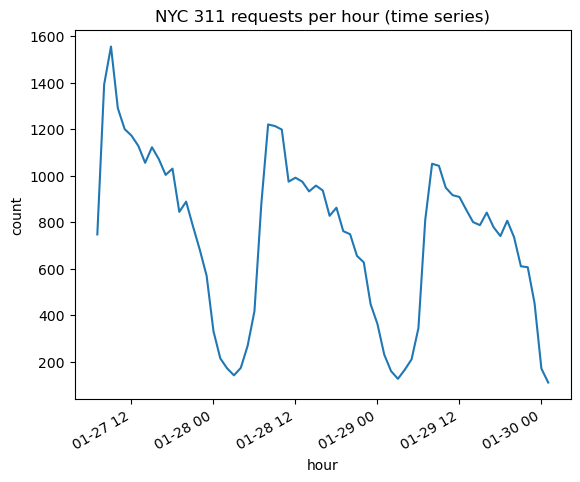

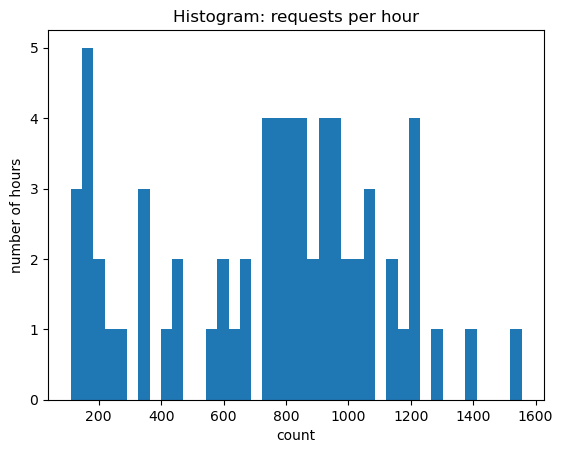

In [23]:
plt.figure()
plt.plot(counts_per_hour.index, counts_per_hour.values)
plt.title("NYC 311 requests per hour (time series)")
plt.xlabel("hour")
plt.ylabel("count")
plt.xticks(rotation=30, ha="right")
plt.show()

# Does this look like a Poisson distribution?
plt.figure()
plt.hist(counts_per_hour.values, bins=40)
plt.title("Histogram: requests per hour")
plt.xlabel("count")
plt.ylabel("number of hours")
plt.show()


### Condition to improve the Poisson story: hour-of-day  

A classic way to reduce overdispersion is to **condition on known structure**  

Compute counts per hour-of-day across the dataset, then look at the distribution within each hour-of-day

In [24]:
# Hour-of-day conditioning
ar["hour_of_day"] = ar["created_date"].dt.hour

hourly_by_hod = ar.groupby(["hour_of_day", "created_hour_bin"]).size().rename("n").reset_index()

summary_hod = hourly_by_hod.groupby("hour_of_day")["n"].agg(["mean", lambda s: s.var(ddof=0)])
summary_hod.columns = ["mean", "var"]
summary_hod["var/mean"] = summary_hod["var"] / summary_hod["mean"]
summary_hod

,mean,var,var/mean
hour_of_day,,,
0,287.666667,7082.888889,24.621862
1,184.666667,2830.222222,15.326113
2,165.000000,36.000000,0.218182
3,133.500000,56.250000,0.421348
4,169.000000,16.000000,0.094675
5,239.000000,841.000000,3.518828
6,380.500000,1332.250000,3.501314
7,811.000000,2774.000000,3.420469
8,1221.000000,19380.666667,15.872782


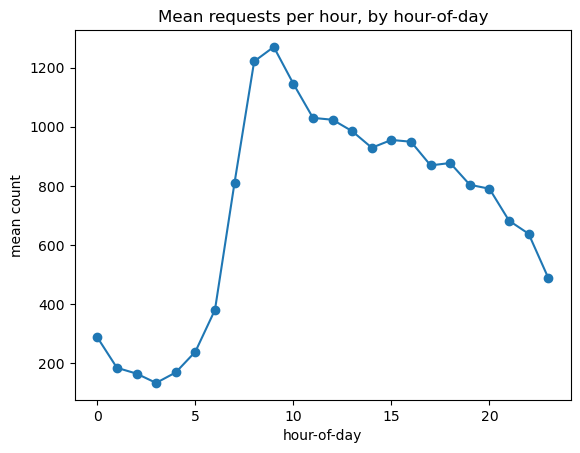

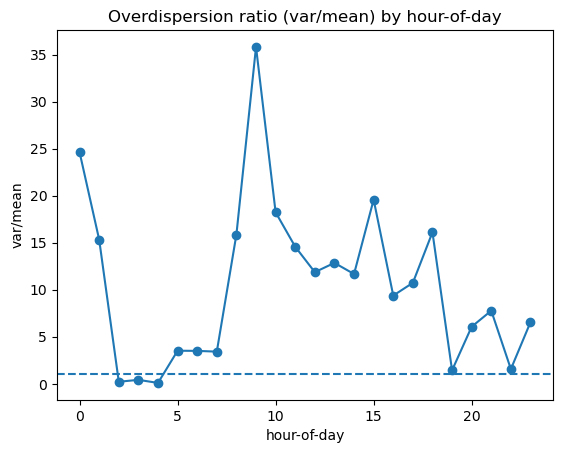

In [25]:
plt.figure()
plt.plot(summary_hod.index, summary_hod["mean"].values, marker="o")
plt.title("Mean requests per hour, by hour-of-day")
plt.xlabel("hour-of-day")
plt.ylabel("mean count")
plt.show()

plt.figure()
plt.plot(summary_hod.index, summary_hod["var/mean"].values, marker="o")
plt.title("Overdispersion ratio (var/mean) by hour-of-day")
plt.xlabel("hour-of-day")
plt.ylabel("var/mean")
plt.axhline(1.0, linestyle="--")
plt.show()

**Interpretation:**  
If conditioning reduces var/mean toward &sim;1, your original overdispersion was partly because the "constant rate" assumption was false.  

If var/mean is still far above 1 even within hour-of-day, you likely have:  
* burstiness / clustering
* additional mixtures (weekday/weekend, boroughs, agencies)

## 4B.4 Binomial-sih: successes out of N (fast resolution) 

**Binomial story:**  
In a group with $N$ cases, each case is a success with probability $p$, independently.  

We will define: 
* `fast_24 = resolution_hours <= 24` (success) and compute successes per group (e.g., by agency).

Then we will show a common failure mode:  
* **same-p assumption breaks** across agencies or across complaint types

In [26]:
closed = closed.copy()

closed["fast_24"] = closed["resolution_hours"] <= 24
closed["fast_72"] = closed["resolution_hours"] <= 72

# Define a "noise" event for conditioning
if "kw_noise" in closed.columns:
    closed["noise"] = closed["kw_noise"].astype(int) == 1
else:
    ct = closed["complaint_topk"].astype(str).str.lower()
    closed["noise"] = ct.str.contains("noise")

closed[["resolution_hours", "fast_24", "fast_72", "noise"]].head()

,resolution_hours,fast_24,fast_72,noise
41,0.373056,True,True,True
43,0.181667,True,True,False
45,0.353056,True,True,False
49,0.300278,True,True,True
51,0.095000,True,True,True


In [27]:
# Binomial-ish view by agency: N, successes, p-hat
if "agency" not in closed.columns:
    raise ValueError("Expected 'agency' column in features.")

by_agency = (
    closed.groupby("agency")
          .agg(N=("fast_24", "size"), successes=("fast_24", "sum"))
)
by_agency["p_hat"] = by_agency["successes"] / by_agency["N"]
by_agency = by_agency.sort_values("N", ascending=False)

by_agency.head(10)


,N,successes,p_hat
agency,,,
NYPD,11440,11437,0.999738
HPD,4458,2297,0.515253
DSNY,794,478,0.602015
DOT,755,689,0.912583
DEP,711,659,0.926864
DHS,227,161,0.709251
DOB,147,126,0.857143
DOHMH,125,95,0.760000
DPR,101,86,0.851485


### Plot: agencies with enough sample size  

Small-$N$ estimates are noisy. We will filter agencies with at least `min_n` cases

Agencies with N >= 500 : 5


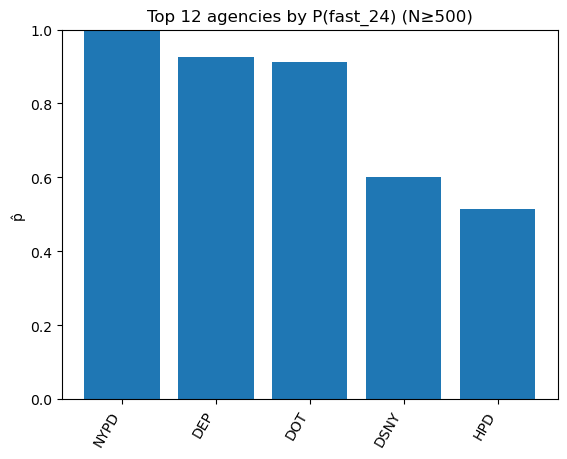

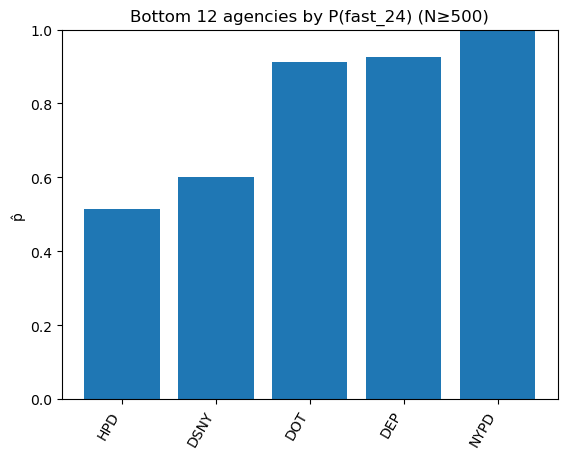

In [28]:
min_n = 500  # adjust as needed for your data size
stable = by_agency[by_agency["N"] >= min_n].sort_values("p_hat", ascending=False)

print("Agencies with N >=", min_n, ":", stable.shape[0])

top_n = 12
top = stable.head(top_n)
bot = stable.tail(top_n).sort_values("p_hat")

plt.figure()
plt.bar(top.index.astype(str), top["p_hat"].values)
plt.title(f"Top {top_n} agencies by P(fast_24) (N≥{min_n})")
plt.ylabel("p̂")
plt.xticks(rotation=60, ha="right")
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.bar(bot.index.astype(str), bot["p_hat"].values)
plt.title(f"Bottom {top_n} agencies by P(fast_24) (N≥{min_n})")
plt.ylabel("p̂")
plt.xticks(rotation=60, ha="right")
plt.ylim(0, 1)
plt.show()

### Same mean, different variance: the "mixture" smell  

If you compute one global (p) and pretend every agency shares it, your binomial model will often be too narrow.  

We will compare:  
* **observed** variability of agency level $p$ vs:
* what would be expected if all agencies truly shared one common $p$ (very rough baseline)

This is an intuition exercise, not a formal test.

In [29]:
global_p = float(closed["fast_24"].mean())
print("Global p = P(fast_24) =", global_p)

# Rough binomial standard error for each agency under "same p" assumption:
stable2 = stable.copy()
stable2["se_binom"] = np.sqrt(global_p * (1 - global_p) / stable2["N"])

stable2["z_like"] = (stable2["p_hat"] - global_p) / stable2["se_binom"]

stable2[["N", "p_hat", "se_binom", "z_like"]].sort_values("z_like", ascending=False).head(10)


Global p = P(fast_24) = 0.8539748068169789


,N,p_hat,se_binom,z_like
agency,,,,
NYPD,11440,0.999738,0.003302,44.149293
DEP,711,0.926864,0.013243,5.503753
DOT,755,0.912583,0.012852,4.560304
DSNY,794,0.602015,0.012532,-20.105038
HPD,4458,0.515253,0.005289,-64.043662


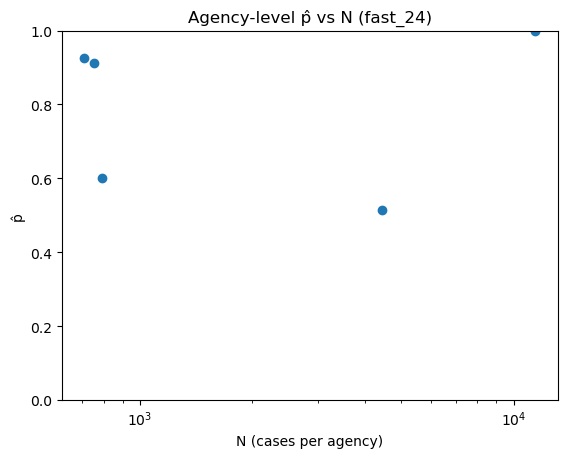

In [30]:
plt.figure()
plt.scatter(stable2["N"], stable2["p_hat"])
plt.title("Agency-level p̂ vs N (fast_24)")
plt.xlabel("N (cases per agency)")
plt.ylabel("p̂")
plt.ylim(0, 1)
plt.xscale("log")
plt.show()


**Interpretation:** If many agencies sit far from the global $p$, the "same-$p$" assumption is false. In ML terms: agecy is a predictive feature, and mixing agencies hides structure.  

Next: condition on `noise` and see whether the story changes.  

In [31]:
# Conditioning: compute p̂_fast_24 by agency, but only for noise cases
noise_only = closed.loc[closed["noise"]].copy()

by_agency_noise = (
    noise_only.groupby("agency")
              .agg(N=("fast_24", "size"), successes=("fast_24", "sum"))
)
by_agency_noise["p_hat_noise"] = by_agency_noise["successes"] / by_agency_noise["N"]

comp = stable2[["N", "p_hat"]].rename(columns={"N": "N_all", "p_hat": "p_hat_all"}).join(
    by_agency_noise[["N", "p_hat_noise"]].rename(columns={"N": "N_noise"}),
    how="left"
).dropna()

comp["delta"] = comp["p_hat_noise"] - comp["p_hat_all"]
comp.sort_values("delta").head(12)


,N_all,p_hat_all,N_noise,p_hat_noise,delta
agency,,,,,
DEP,711,0.926864,159.0,0.779874,-0.146989
NYPD,11440,0.999738,1723.0,1.000000,0.000262


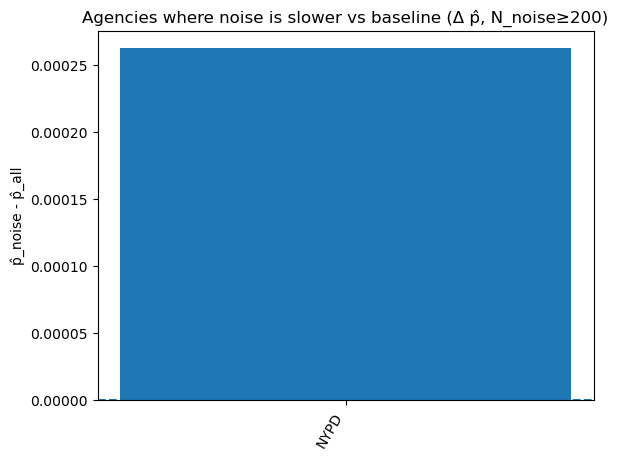

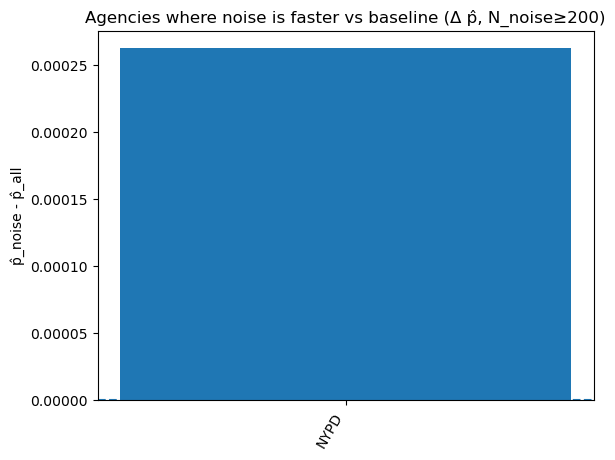

In [32]:
# Visualize agencies where noise is much faster/slower than baseline
comp2 = comp.copy()
comp2 = comp2[comp2["N_noise"] >= 200].sort_values("delta")  # avoid noisy deltas

k = 12
worst = comp2.head(k)
best = comp2.tail(k)

plt.figure()
plt.bar(worst.index.astype(str), worst["delta"].values)
plt.title(f"Agencies where noise is slower vs baseline (Δ p̂, N_noise≥200)")
plt.ylabel("p̂_noise - p̂_all")
plt.xticks(rotation=60, ha="right")
plt.axhline(0, linestyle="--")
plt.show()

plt.figure()
plt.bar(best.index.astype(str), best["delta"].values)
plt.title(f"Agencies where noise is faster vs baseline (Δ p̂, N_noise≥200)")
plt.ylabel("p̂_noise - p̂_all")
plt.xticks(rotation=60, ha="right")
plt.axhline(0, linestyle="--")
plt.show()

## 4B.5 Normal-ish: aggregates and why raw durations rarely look normal.

Raw service times are often:  
* right-skewed
* heavy-tailed
* censored/truncated (open cases, missing timestamps)

But **aggregates** like mean resolution time per day, or mean residuals, make look more normal  

Compare:
* raw `resolution_hours`
* daily mean `resolution_hours` and log1p variants

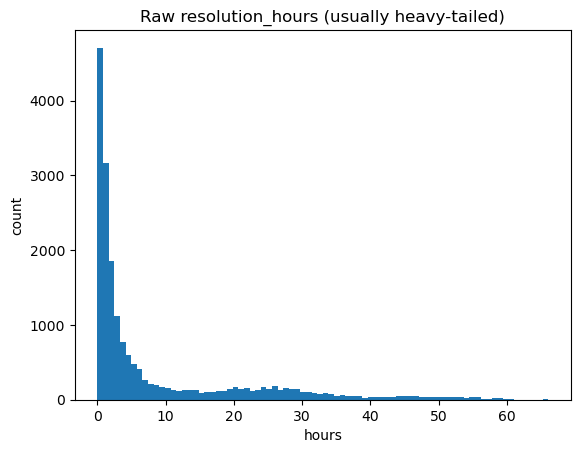

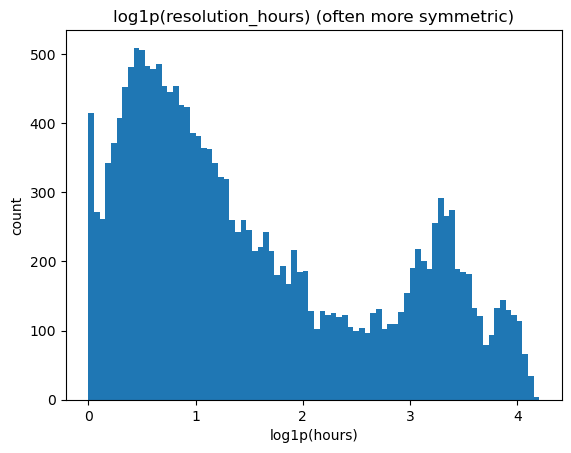

In [33]:
plt.figure()
plt.hist(closed["resolution_hours"], bins=80)
plt.title("Raw resolution_hours (usually heavy-tailed)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(closed["resolution_hours"]), bins=80)
plt.title("log1p(resolution_hours) (often more symmetric)")
plt.xlabel("log1p(hours)")
plt.ylabel("count")
plt.show()


In [34]:
# Aggregate by day: mean resolution time
if "created_day" in closed.columns:
    created_day = pd.to_datetime(closed["created_day"], errors="coerce")
else:
    created_day = pd.to_datetime(closed["created_date"], errors="coerce").dt.floor("D")

closed2 = closed.copy()
closed2["created_day_bin"] = created_day

daily = (
    closed2.dropna(subset=["created_day_bin"])
           .groupby("created_day_bin")["resolution_hours"]
           .mean()
           .rename("mean_resolution_hours")
           .sort_index()
)

print("Daily mean series length:", len(daily))
daily.head()

# Note: This current dataset has only a week of data, so will limit this technique

Daily mean series length: 4


created_day_bin
2026-01-27    13.968220
2026-01-28     8.018568
2026-01-29     2.632212
2026-01-30     0.568265
Name: mean_resolution_hours, dtype: float64

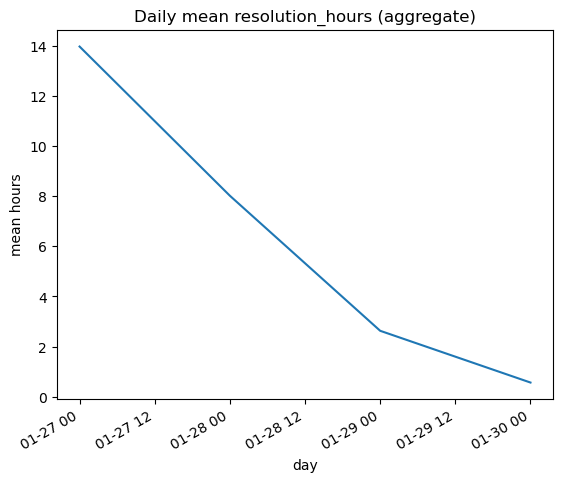

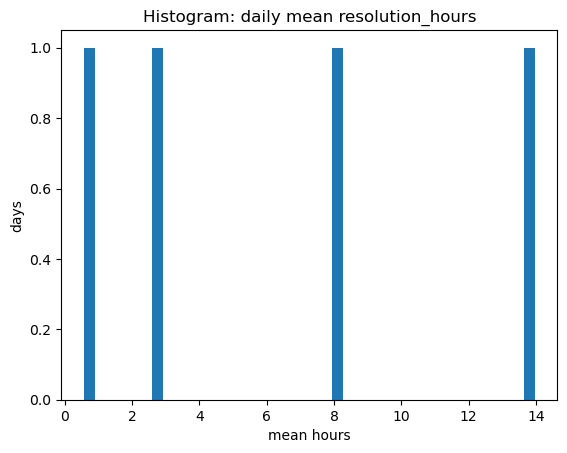

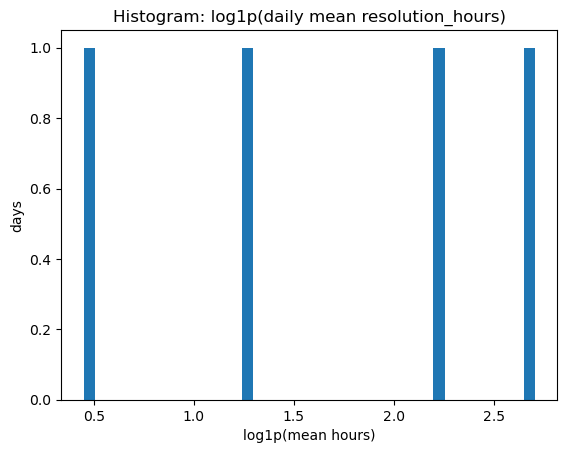

In [35]:
plt.figure()
plt.plot(daily.index, daily.values)
plt.title("Daily mean resolution_hours (aggregate)")
plt.xlabel("day")
plt.ylabel("mean hours")
plt.xticks(rotation=30, ha="right")
plt.show()

plt.figure()
plt.hist(daily.values, bins=40)
plt.title("Histogram: daily mean resolution_hours")
plt.xlabel("mean hours")
plt.ylabel("days")
plt.show()

plt.figure()
plt.hist(np.log1p(daily.values), bins=40)
plt.title("Histogram: log1p(daily mean resolution_hours)")
plt.xlabel("log1p(mean hours)")
plt.ylabel("days")
plt.show()


**Interpretation:** If daily means look closer to symmetric/normal-ish than raw durations,
that’s CLT intuition in action: *averages can look normal even when raw data is not*.

But this does **not** mean extremes disappear. Tail risk is still real in raw durations.

## 4B.6 When assumptions fail: quick failure-mode checklist on your own variable

Pick one variable in NYC311 and run this checklist:

1) Is it a count? (Poisson-ish)  
2) Is it successes out of N? (Binomial-ish)  
3) Is it an aggregate/residual? (Normal-ish)  
4) Which assumption fails first?
   - constant rate / same p
   - independence
   - stationarity over time
   - symmetry / finite variance

Below is a helper cell you can reuse to quickly test “Poisson smell” and “mixture smell.”

In [36]:
def poisson_diagnostics(counts: pd.Series, name: str = "counts") -> pd.Series:
    counts = counts.astype(float)
    mu = float(counts.mean())
    var = float(counts.var(ddof=0))
    return pd.Series({
        "name": name,
        "n_windows": int(counts.shape[0]),
        "mean": mu,
        "var": var,
        "var/mean": var / mu if mu > 0 else float("nan"),
        "p90": float(np.quantile(counts, 0.90)),
        "p95": float(np.quantile(counts, 0.95)),
        "p99": float(np.quantile(counts, 0.99)),
    })


In [37]:
def binomial_diagnostics(series: pd.Series, n: int, name: str = "values") -> pd.Series:
    series = series.astype(float)
    p_hat = float(series.mean() / n)  # estimated p
    expected_var = n * p_hat * (1 - p_hat)  # theoretical binomial variance
    observed_var = float(series.var(ddof=0))
    return pd.Series({
        "name": name,
        "n_trials": n,
        "estimated_p": p_hat,
        "expected_var (binomial)": expected_var,
        "observed_var": observed_var,
        "var_ratio": observed_var / expected_var if expected_var > 0 else float("nan"),
        "p90": float(np.quantile(series, 0.90)),
        "p99": float(np.quantile(series, 0.99)),
    })

In [38]:
def normal_diagnostics(series: pd.Series, name: str = "values") -> pd.Series:
    series = series.astype(float)
    mu = float(series.mean())
    median = float(series.median())
    std = float(series.std(ddof=0))
    skewness = float(series.skew())
    kurtosis = float(series.kurt())
    return pd.Series({
        "name": name,
        "n": int(series.shape[0]),
        "mean": mu,
        "median": median,
        "mean/median ratio": mu / median if median != 0 else float("nan"),
        "std": std,
        "skewness": skewness,  # ~0 is Normal-ish
        "excess_kurtosis": kurtosis,  # ~0 is Normal-ish
    })

In [39]:
# Example: counts per day (often shows stronger seasonality)
ar["created_day_bin"] = ar["created_date"].dt.floor("D")
counts_per_day = ar.groupby("created_day_bin").size().rename("n_requests").sort_index()

poisson_diagnostics(counts_per_day, "requests per day")


name         requests per day
n_windows                   4
mean                  12500.0
var                50452773.5
var/mean           4036.22188
p90                   17344.2
p95                   17436.6
p99                  17510.52
dtype: object

In [40]:
# Pick your variable
constant = "median_resolution_hours"
variable = ar[constant]

# Run all three diagnostics
poisson_result = poisson_diagnostics(variable, constant)
normal_result = normal_diagnostics(variable, constant)
binomial_result = binomial_diagnostics(variable, n=100, name=constant)  # replace n with something meaningful

# Display results
print("=== Poisson ===")
print(poisson_result)

print("\n=== Normal ===")
print(normal_result)

print("\n=== Binomial ===")
print(binomial_result)

=== Poisson ===
name         median_resolution_hours
n_windows                      50000
mean                        2.651272
var                         1.314306
var/mean                    0.495726
p90                         4.092778
p95                         4.092778
p99                         4.092778
dtype: object

=== Normal ===
name                 median_resolution_hours
n                                      50000
mean                                2.651272
median                                  2.39
mean/median ratio                   1.109319
std                                 1.146432
skewness                             0.18333
excess_kurtosis                    -1.505858
dtype: object

=== Binomial ===
name                       median_resolution_hours
n_trials                                       100
estimated_p                               0.026513
expected_var (binomial)                    2.58098
observed_var                              1.314306
var_ratio  

## 4B.7 Deliverable: Write the distribution story

Using the template, include:  
* which variable was analyzed (count/success/duration/aggregate)
* which distribution story is plausible and why
* which assumption fails and evidence of failure
* what conditioning makes the story more believable
* what should be done differently in a modeling pipeline because of this information

### My NYC 311 distribution story:  

* **Variable:** `median_resolution_hours` - duration measuring median time to resolve a NYC311 complaint
* **Population/slice:** All 50,000 complaints in the dataset, aggregated at the agency level. Each row carries the agency's typical resolution time 
* **Candidate distribution story:** Normal
* **Why it seemed plausible:** Skewness of 0.18 is close to 0, suggesting symmetry. 
* **Assumption failure observed:** It is not Poisson or Binomial
* **Evidence:** var/mean of 0.496 rules out Poisson. No natural N trials structure rules out Binomial.
* **Conditioning that improved the story:** Splitting by agency or complaint type
* **Decision impact:** Add agency as a conditioning feature

# Module 4.C Estimation & Inference on NYC 311

This lab uses NYC 311 to practice **inference with production realism:**  
* Slice responsibly (**closed cases only**) so outcomes are observed (avoid censoring).
* Build **confidence intervals** (uncertainty on estimates).
* Run **hypothesis tests** (structured decisions).
* Use **ANOVA** to compare many groups at once.
* Translate results into a short, honest narrative (what you can and cannot claim).

**Deliverable:** Describe one inference claim that was made and its limitations.

In [41]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

rng = np.random.default_rng(0)


## 4C.0 Quick reference (conceptual, not a proof)

### Confidence interval (mean, large-sample)  
If you estimate a mean with sample mean `$\bar{x}$` and sample std `s` from `n` observations, a common 95% CI is:  
* CI approx: $\bar{x} \pm 1.96 * s / \sqrt{n}$

Interpretation discipline:  
* The **parameter** (true mean) is fixed.
* The **interval** is random (depends on the sample)
* 95% CI - means the procedure captures the true mean ~95% of the time under assumptions.

### Hypothesis test (mean, one-sample t-test)
* Null: mean equals some value (e.g., global mean)
* Alternative: mean differs
* p-value: how surprising your data is **if the null were true**

### ANOVA (many groups)  
ANOVA tests whether **at least one** group mean differs. It does not tell you **which** groups differ. Follow-up analysis is needed

## 4C.1 Load the NYC 311 feature table  
We reuse the normalized parquet produced in 3.A.

In [42]:
M3_DATA_DIR = Path("work/m3/data") 
NORM_PATH = M3_DATA_DIR / "nyc311_features_norm.parquet"

if not NORM_PATH.exists():
    raise FileNotFoundError(
        f"Missing normalized cache at {NORM_PATH}. "
        "Run Module 3.A first to create it."
    )

df = pd.read_parquet(NORM_PATH)
print("Loaded:", NORM_PATH)
print("Shape:", df.shape)
df.head(3)


Loaded: work/m3/data/nyc311_features_norm.parquet
Shape: (50000, 25)


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,2.C_features_parquet,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,2.C_features_parquet,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet,4


## 4C.2 Slice responsibly: Closed cases with valid resolution time

Why:  
* Open/in-progress cases often have missing resolution times.
* Mixing closed and open cases creates **censoring**: outcomes are not fully observed.
* Inference assumes you are analyzing an observed outcome from a defined population

We will build a clean inference table:
* `is_closed == 1` (or status indicates closed)
* `resolution_hours` exists and is finite and nonnegative

In [43]:
df2 = df.copy()

if "is_closed" in df2.columns:
    is_closed = df2["is_closed"] == 1
elif "status" in df2.columns:
    is_closed = df2["status"].astype(str).str.upper().isin(["CLOSED", "RESOLVED"])
else:
    is_closed = pd.Series([True] * len(df2), index=df2.index)

if "resolution_hours" not in df2.columns:
    raise ValueError("Expected 'resolution_hours' column.")

y = df2["resolution_hours"].astype(float)
mask = is_closed & y.notna() & np.isfinite(y) & (y >= 0)

closed = df2.loc[mask].copy()

print("All rows:", len(df2))
print("Closed + valid resolution:", len(closed))
closed[["agency", "borough_norm", "complaint_topk", "resolution_hours"]].head()

All rows: 50000
Closed + valid resolution: 18894


,agency,borough_norm,complaint_topk,resolution_hours
41,NYPD,BRONX,noise - residential,0.373056
43,NYPD,QUEENS,illegal parking,0.181667
45,NYPD,QUEENS,illegal parking,0.353056
49,NYPD,BRONX,other,0.300278
51,NYPD,MANHATTAN,other,0.095000


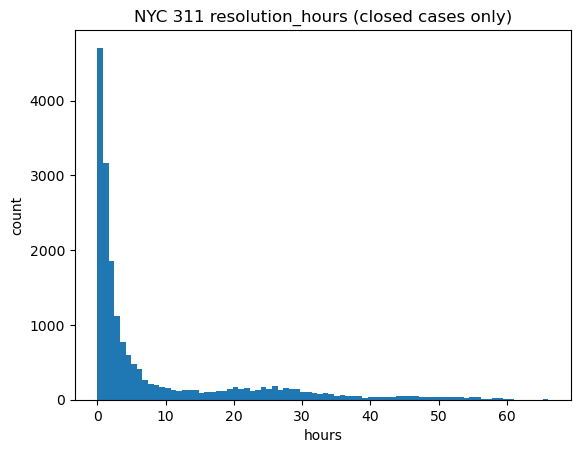

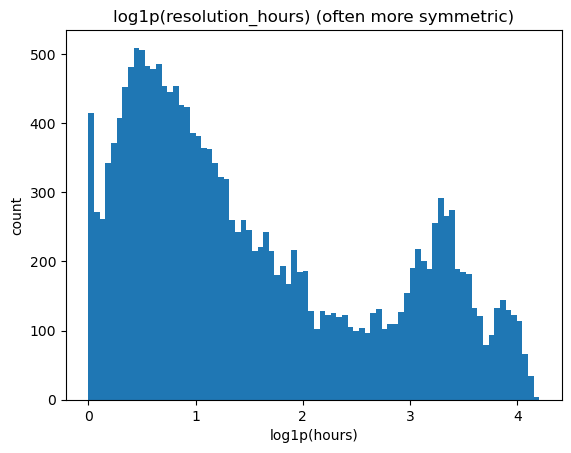

In [44]:
plt.figure()
plt.hist(closed["resolution_hours"], bins=80)
plt.title("NYC 311 resolution_hours (closed cases only)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(closed["resolution_hours"]), bins=80)
plt.title("log1p(resolution_hours) (often more symmetric)")
plt.xlabel("log1p(hours)")
plt.ylabel("count")
plt.show()

## 4C.3 Confidence intervals by group (agency)

We compute approximate 95% confidence intervals for **mean resolution time** by agency  

Notes:  
* `resolution_hours` is often heavy-tailed &rarr; means are tail-sensitive.
* We will filter to agencies with enough `n` for stable estimates.
* In 4.D we will bootstrap CIs 

In [45]:
import math
import numpy as np
import pandas as pd

def mean_ci_normal_approx(x: np.ndarray) -> tuple[float, float, float, int, float]:
    """
    Large-sample normal CI for mean: xbar +/- 1.96 * s/sqrt(n)
    Returns (xbar, lo, hi, n, s).
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = int(x.size)
    if n < 2:
        return (float("nan"), float("nan"), float("nan"), n, float("nan"))
    xbar = float(x.mean())
    s = float(x.std(ddof=1))
    half = 1.96 * s / math.sqrt(n)
    return xbar, xbar - half, xbar + half, n, s

if "agency" not in closed.columns:
    raise ValueError("Expected 'agency' column.")

rows = []
for agency, s in closed.groupby("agency")["resolution_hours"]:
    xbar, lo, hi, n, sd = mean_ci_normal_approx(s.values)
    rows.append((agency, n, xbar, lo, hi, hi - lo, sd, float(s.median())))

ci_agency = pd.DataFrame(
    rows,
    columns=["agency", "n", "mean", "ci_lo", "ci_hi", "ci_width", "std", "median"]
).sort_values("n", ascending=False)

ci_agency.head(10)

,agency,n,mean,ci_lo,ci_hi,ci_width,std,median
10,NYPD,11440,2.065904,2.022006,2.109803,0.087797,2.395548,1.278056
9,HPD,4458,23.999943,23.556297,24.443589,0.887292,15.112999,23.354861
8,DSNY,794,18.759539,17.795578,19.723499,1.927921,13.858409,20.099722
6,DOT,755,8.385227,7.589356,9.181097,1.591741,11.157318,2.448611
1,DEP,711,6.089803,5.329857,6.849749,1.519892,10.338591,1.033333
2,DHS,227,18.050852,15.866537,20.235167,4.368630,16.790830,12.941389
3,DOB,147,9.495754,7.753394,11.238114,3.484721,10.778059,8.230000
5,DOHMH,125,13.816304,12.100036,15.532573,3.432538,9.790035,14.663611
7,DPR,101,12.830839,10.712579,14.949099,4.236520,10.861353,13.409167
4,DOE,75,11.884456,9.437256,14.331655,4.894398,10.812942,7.605000


In [46]:
min_n = 800
stable = ci_agency[ci_agency["n"] >= min_n].sort_values("mean").copy()
print("Stable agencies (n>=min_n):", stable.shape[0])
stable.head()

Stable agencies (n>=min_n): 2


,agency,n,mean,ci_lo,ci_hi,ci_width,std,median
10,NYPD,11440,2.065904,2.022006,2.109803,0.087797,2.395548,1.278056
9,HPD,4458,23.999943,23.556297,24.443589,0.887292,15.112999,23.354861


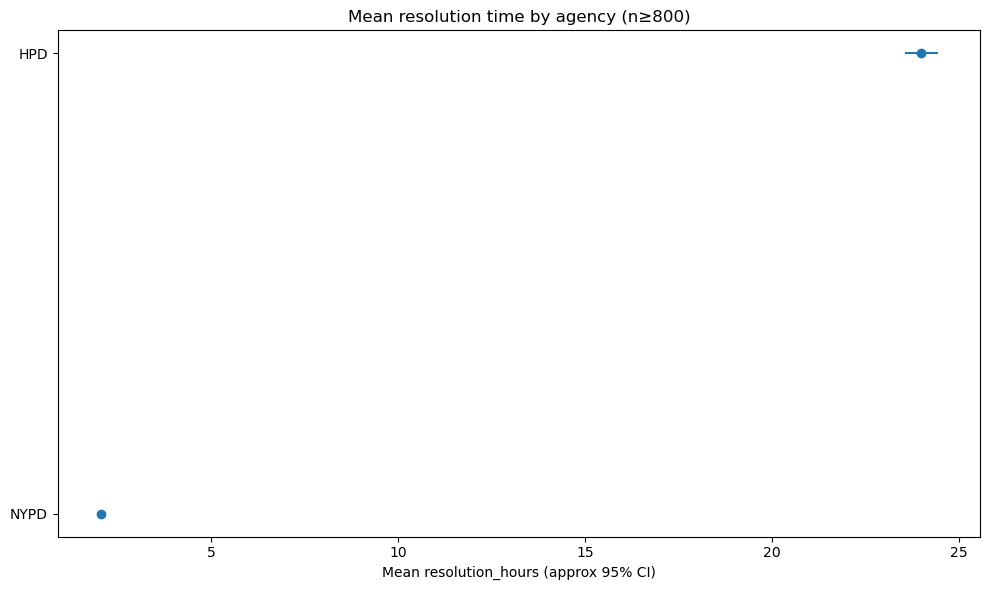

In [47]:
plt.figure(figsize=(10, 6))
ypos = np.arange(len(stable))
plt.hlines(ypos, stable["ci_lo"], stable["ci_hi"])
plt.plot(stable["mean"], ypos, "o")
plt.yticks(ypos, stable["agency"].astype(str))
plt.xlabel("Mean resolution_hours (approx 95% CI)")
plt.title(f"Mean resolution time by agency (n≥{min_n})")
plt.tight_layout()
plt.show()

## 4C.4 Hypothesis test: does one agency differ from the global mean?  
We will pick one agency and test whether its mean differs from the global mean.  
* **Null:** agency means equals global mean
* **Alternative:** different
  
Then we compute effect size:
* absolute difference (hours)
* Cohen's d(standardized; interpret cautiously for heavy tails)

This is an association claim, not a causal claim

In [48]:
candidate = stable["agency"].iloc[0] if len(stable) else ci_agency["agency"].iloc[0]
candidate

'NYPD'

In [49]:
x_all = closed["resolution_hours"].astype(float).values
x_ag = closed.loc[closed["agency"] == candidate, "resolution_hours"].astype(float).values

mu0 = float(np.mean(x_all))
xbar = float(np.mean(x_ag))
s = float(np.std(x_ag, ddof=1))
n = int(len(x_ag))

print("Agency:", candidate)
print("n:", n)
print("Agency mean:", xbar)
print("Global mean:", mu0)
print("Difference (hours):", xbar - mu0)

Agency: NYPD
n: 11440
Agency mean: 2.065904283216783
Global mean: 8.827547560660058
Difference (hours): -6.761643277443275


In [50]:
try:
    from scipy import stats
    t_stat, p_val = stats.ttest_1samp(x_ag, popmean=mu0, alternative="two-sided")
    print("t-stat:", float(t_stat))
    print("p-val :", float(p_val))
except Exception:
    import math
    z = (xbar - mu0) / (s / np.sqrt(n))
    p_val = 2 * (1 - 0.5 * (1 + math.erf(abs(z) / math.sqrt(2))))
    print("scipy unavailable; used z-approx")
    print("z:", float(z))
    print("approx p:", float(p_val))

t-stat: -301.8981049566344
p-val : 0.0


In [51]:
abs_diff = xbar - mu0
cohens_d = abs_diff / s if s > 0 else float("nan")

print("Absolute difference (hours):", float(abs_diff))
print("Cohen's d:", float(cohens_d))

Absolute difference (hours): -6.761643277443275
Cohen's d: -2.8225872451846263


### Conditioning check (optional): noise complaints only  
A common failure mode in inference is **mixture**: the agency might look "fast" because it handles different complaint mixes.  

We will condition on noise complaints as an example.

In [52]:
tmp = closed.copy()
if "kw_noise" in tmp.columns:
    tmp["noise"] = tmp["kw_noise"].astype(int) == 1
else:
    ct = tmp["complaint_topk"].astype(str).str.lower()
    tmp["noise"] = ct.str.contains("noise")

x_all_noise = tmp.loc[tmp["noise"], "resolution_hours"].astype(float).values
x_ag_noise = tmp.loc[(tmp["noise"]) & (tmp["agency"] == candidate), "resolution_hours"].astype(float).values

print("Noise slice sizes:")
print("  global noise n:", len(x_all_noise))
print("  agency noise n:", len(x_ag_noise))

if len(x_ag_noise) >= 30 and len(x_all_noise) >= 30:
    mu0_noise = float(np.mean(x_all_noise))
    xbar_noise = float(np.mean(x_ag_noise))
    print("Noise slice means:")
    print("  agency mean:", xbar_noise)
    print("  global mean:", mu0_noise)
    print("  difference :", xbar_noise - mu0_noise)
else:
    print("Not enough noise rows for a stable conditioned comparison.")

Noise slice sizes:
  global noise n: 1882
  agency noise n: 1723
Noise slice means:
  agency mean: 2.2136647965434966
  global mean: 3.3704362970834807
  difference : -1.1567715005399841


## 4C.5 ANOVA: compare multiple agencies at once

ANOVA tests whether **at least one** mean differs across multiple groups.  

We will run ANOVA on the top K agencies by sample size (among stable agencies).  

Interpretation:  
* small p-value &rarr; evidence that not all group means are equal
* does not tell you which agencies differ  

In [53]:
K = 8
top_agencies = (
    ci_agency[ci_agency["n"] >= min_n]
    .sort_values("n", ascending=False)
    .head(K)["agency"]
    .tolist()
)
top_agencies

['NYPD', 'HPD']

In [54]:
samples = [closed.loc[closed["agency"] == a, "resolution_hours"].astype(float).values for a in top_agencies]
{a: len(s) for a, s in zip(top_agencies, samples)}


{'NYPD': 11440, 'HPD': 4458}

In [55]:
try:
    from scipy import stats
    F, p = stats.f_oneway(*samples)
    print("ANOVA F:", float(F))
    print("ANOVA p:", float(p))
except Exception as e:
    print("scipy unavailable; cannot run ANOVA via stats.f_oneway.")
    print("Error:", e)

ANOVA F: 22639.42705990387
ANOVA p: 0.0


### Quick diagnostic: do group variances look similar?  
Not a formal test, just a smell check. Large variance differences mean classical ANOVA assumptions are strained.  

In [56]:
rows = []
for a in top_agencies:
    x = closed.loc[closed["agency"] == a, "resolution_hours"].astype(float).values
    rows.append((a, len(x), float(np.mean(x)), float(np.std(x, ddof=1))))
pd.DataFrame(rows, columns=["agency", "n", "mean", "std"]).sort_values("std", ascending=False)


,agency,n,mean,std
1,HPD,4458,23.999943,15.112999
0,NYPD,11440,2.065904,2.395548


## 4C.6 Multiple comparisons warning  
If you run many tests at alpha=0.05, false positives become likely.  

This is hy:  
* define hypotheses before looking
* limit the number of tests
* adjust for multiple comparisons
* validate with resampling (Module 4.D)

In [57]:
alpha = 0.05
m = 20
print("Expected false positives (m*alpha):", m * alpha)
print("P(at least one false positive) if independent:", 1 - (1 - alpha)**m)


Expected false positives (m*alpha): 1.0
P(at least one false positive) if independent: 0.6415140775914581


## 4C.7 Deliverable: One inference claim + limitations  
Write 5-8 bullets describing:  
* your slice (closed-only; any filters)
* your estimate and CI (by agency or borough)
* your hypothesis test (what $H_0$ was; p-value; effect size)
* what ANOVA suggested
* limitations (confounding/mixture, heavy tails, time dependence, selection bias)
* what you would do next(conditioning, bootstrap CI, permutation test, robust summaries)

### My NYC 311 inference narrative  
* **Slice / population:** Closed NYC 311 cases with valid, non-negative `resolution_hours`. 
* **Metric:** Mean `resolution_hours` by agency. How long on average it takes an agency to close a complaint
* **Estimate + CI:** NYPD mean &approx; 2.07 hours with a 95% CI of [2.02, 2.11], HPD mean &approx; 24.0 hours with a 95% CI of [23.56, 24.44]. 4C.3.
* **Hypothesis test:** $H_0$ = NYPD's mean resolution time equals the global mean (&sim;8.83 hours). The t-statistic was -302 with $p \approx 0$, so we reject the null. NYPD resolves cases roughly 6.76 hours faster than the global average.
* **Effect size:** Cohen's d &approx; -2.82, which is extremely large. Operationally, nearly 7 hours faster per case is meaningful at NYPD's volume of 11,440 cases.
* **ANOVA result:** F &approx; 22,639 with p &approx; 0, confirming that at least one agency mean differs significantly. However, ANOVA only tells that groups differ, not which ones.
* **Limitations:** The biggest one is the mixture problem. NYPD handles a different complaint mix than HPD. 
* **Next validation step:** Bootstrap CIs, will give better uncertainty estimates given the heavy tails.